In [14]:
from bath_constants import (
    Boltzmann,
    hbar,
    ############## Bath parameters ##############
    Temp,
    eta,
    cutoff,
    args_paper,
    args_drude_lorentz,
    args_ohmic,
)
# Import the functions from test_baths.py
from test_baths import (
    spectral_density_func_paper,
    Power_spectrum_func_paper,
)
from concurrent.futures import ProcessPoolExecutor, as_completed
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scipy.constants as const
import matplotlib as mpl
from qutip import *
import numpy as np
import itertools
import os

# Import the outsourced plot settings
from plot_settings import *

# Allows for interactive plots
# %matplotlib notebook
%matplotlib inline

In [ ]:
# =============================
# SYSTEM PARAMETERS     (**changeable**)
# =============================
global N_atoms, Coupled, ODE_Solver, omega_laser, E0, E_freqs, E_amps, omega_a, mu_a, rabi_0, delta, theta, J, RWA_laser
# CAN ONLY HANDLE 2 ATOMS for MY solver
N_atoms = 2  # Set the number of atoms

fac_two_pi = 1  # * 2 * np.pi  # Factor to convert from Hertz to angular frequency [fs^-1] -> [rads/ fs] -> also have to adjust the plotting of the 2D spectrum
RWA_laser  = False  #  only valid for omega_laser ~ omega_a ~ omega_b
Coupled    = True  # Set coupling condition
ODE_Solver = "MY"  # Choose between "BR" (Bloch-Redfield) or "ME" (Master Equation) or "MY" (solve the EOMs from the paper)


### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]

### Define Atomic States
atom_g, atom_e = basis(2, 0), basis(2, 1)  # Ground, Excited states


### define the laser parameters
omega_laser = (
    fac_two_pi * 0.48
)  #  [fs⁻¹] = 16000 cm-1 / in the middle of the two transitions
E_freqs = [omega_laser] * 3  # Laser frequencies
E0 = 0.1  # (**changeable*) Amplitude of the laser field -> excitation should be <=1%!!!
E_amps = [E0, E0, 1e-1 * E0]  # third one is small to simulate a probe field

### Initialize variables that are shared across cases but may be not used in one
omega_b, mu_b, delta, theta, J = None, None, None, None, None

### Coupling to the bath
# Linblad Case
gamma_phi, gamma_0 = (
    eta,
    eta / 3,
)  # (**changeable**):  Dephasing and Decay rates with MESOLVE

### Functions to calculate the diagonal hamiltonian of the
def Hamilton_dimer_sys(hbar, omega_a, omega_b, J):
    H = hbar * (
        omega_a * ket2dm(tensor(atom_e, atom_g))
        + omega_b * ket2dm(tensor(atom_g, atom_e))
        + J
        * (
            tensor(atom_e, atom_g) * tensor(atom_g, atom_e).dag()
            + tensor(atom_g, atom_e) * tensor(atom_e, atom_g).dag()
        )
        + (omega_a + omega_b) * ket2dm(tensor(atom_e, atom_e))
    )
    return H

def calc_mu(H, mu_a, mu_b, theta):
    eigenvecs = H.eigenstates()[1]
    mu_10 = -mu_a * np.sin(theta) + mu_b * np.cos(theta)
    sigma_m_10 = mu_10 * (eigenvecs[0] * eigenvecs[1].dag()).unit()

    mu_20 = mu_a * np.cos(theta) + mu_b * np.sin(theta)
    mu_31 = -mu_b * np.sin(theta) + mu_a * np.cos(theta)
    mu_32 = mu_b * np.cos(theta) + mu_a * np.sin(theta)

    sigma_m_20 = mu_20 * (eigenvecs[0] * eigenvecs[2].dag()).unit()
    sigma_m_32 = mu_31 * (eigenvecs[1] * eigenvecs[3].dag()).unit()
    sigma_m_31 = mu_32 * (eigenvecs[2] * eigenvecs[3].dag()).unit()

    return [sigma_m_10, sigma_m_20, sigma_m_31, sigma_m_32]

psi_ini = ket2dm(tensor(atom_g, atom_g))  # initial state

pulse_duration = 15  # fs

### If the excited states are coupled -> modify the energy levels
if Coupled:
    J = 0.009  # fac_twopi * c * 300
    omega_a = fac_two_pi * 0.486  # fac_twopi * c * 16200
    omega_b = fac_two_pi * 0.474  # fac_twopi * c * 15800
    mu_a = 1
    mu_b = -0.23
else:
    J = 0.0
    omega_a = 0.4908  # fac_twopi * c * 16360
    omega_b = 0.4692  # fac_twopi * c * 15640
    mu_a = 1
    mu_b = 2 * mu_a

theta = np.arctan(2 * J / (omega_a - omega_b)) / 2

H0 = Hamilton_dimer_sys(hbar, omega_a, omega_b, J)


### NEW: TRY THE DIAGONALIZATION OF THE HAMILTONIAN; LIKE IN THE PAPER
# eigenenergies, eigenstates = H0.eigenstates()
# sm_list = calc_mu(H0, mu_a, mu_b, theta)
eigenenergy_1 = 1/2 * (omega_a + omega_b) - 1/2 * np.sqrt((omega_a - omega_b) ** 2 + 4 * J**2)
eigenenergy_2 = 1/2 * (omega_a + omega_b) + 1/2 * np.sqrt((omega_a - omega_b) ** 2 + 4 * J**2)
eigenenergy_3 = omega_a + omega_b
eigenenergies = [0, eigenenergy_1, eigenenergy_2, eigenenergy_3] 




# Rabi oscillation things / coupling to the laser
g_value = (
    mu_a * mu_b
) * E0  # TODO check.  this might lead to a uncorrect rabi period
rabi_0 = g_value / hbar
rabi_gen = np.sqrt(
    rabi_0**2
)  # Not really the rabi freq, because i dont really take detuning into account, because i have 2 atoms

# Coupling to the environment
cplng_ops_to_env = [
    ket2dm(tensor(atom_e, atom_g)),
    ket2dm(tensor(atom_g, atom_e)),
    ket2dm(tensor(atom_e, atom_e)),
]

Deph_op = sum(cplng_ops_to_env)

a_ops_list = [
    [
        cplng_ops_to_env[0],
        lambda w: spectral_density_func_paper(w, args_paper),
    ],  # atom A with ohmic_spectrum
    [
        cplng_ops_to_env[1],
        lambda w: spectral_density_func_paper(w, args_paper),
    ],  # atom B with ohmic_spectrum
    [
        cplng_ops_to_env[2],
        lambda w: spectral_density_func_paper(2 * w, args_paper),
    ],  # double excited state with 2 * ohmic_spectrum
]

SM_op = sum(sm_list)
Dip_op = SM_op + SM_op.dag()

t_max_L = 6 * 2 * np.pi / omega_laser  # Just the six periods of the laser rotation
t_prd = 2 * np.pi / rabi_gen
t_max_r = max(600, 5 * t_prd)  # (**changeable**) # 5 periods of the rabi oscillation
t_max = t_max_r
fine_spacing = 0.1 * min(t_prd, pulse_duration)
Delta_ts = [pulse_duration / 2] * 3
print("Period for one Rabi oscillation: T/fs  = ", t_prd)

c_ops_list = [np.sqrt(gamma_phi) * Deph_op]  # np.sqrt(gamma_0) * SM_op]#,
e_ops_list = [ket2dm(v) for v in H0.eigenstates()[1]]
e_ops_labels = [f"|{i}" + r"$\rangle$" for i in range(len(H0.eigenstates()[1]))]

Period for one Rabi oscillation: T/fs  =  273.18196987737326


In [ ]:
# =============================
# MORE FUNCTIONS
# =============================
def plot_positive_color_map(
    datas,
    T_wait=np.inf,
    space="real",
    type="real",
    positive=False,
    safe=False,
    output_dir=None,
    ODE_Solver=None,
):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        datas (tuple): Tuple containing (x, y, data) where x and y are 1D arrays and data is a 2D array.
        T_wait (float): waiting time tp include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use ONLY positive values of x and y.
        safe (bool): If True, saves the plot to a file.
        output_dir (str, optional): Directory to save the plot.

    Returns:
        None
    """
    # Ensure datas is a tuple with (x, y, data)
    if not isinstance(datas, tuple) or len(datas) != 3:
        raise ValueError("datas must be a tuple of (x, y, data)")

    x, y, data = datas

    # Validate that x, y, and data are numpy arrays
    x = np.array(x)
    y = np.array(y)
    data = np.array(data)

    # Check if data dimensions match x and y
    if data.shape[1] != len(x):
        raise ValueError(
            f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]})."
        )
    if data.shape[0] != len(y):
        raise ValueError(
            f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]})."
        )

    # Filter for positive x and y values if requested
    if positive:
        positive_x_indices = np.where(x > 0)[0]
        positive_y_indices = np.where(y > 0)[0]
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    # Set the label and title based on the space
    label = r"$\propto E_{\text{out}} / E_{0}$"

    if space != "real" and space != "freq":
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")
    elif space == "real":
        colormap = "viridis"
        title = r"$\text{Real space 2D Spectrum}$"
        if T_wait != np.inf:
            title += f" \text{{at}} T ={T_wait:.2f}"
        x_title = r"$t_{\text{det}}$ [fs]"
        y_title = r"$\tau_{\text{coh}}$ [fs]"
    elif space == "freq":
        x = (
            x * 1.6 / 0.48
        )  # BACK conversion from fs-1 to 10^4 cm-1              0.48 fs-1 = 16000 cm-1
        y = y * 1.6 / 0.48  # BACK conversion
        colormap = "plasma"
        if type == "real":
            title = r"$\text{Freq space, Real 2D Spectrum}$"
            data = np.real(data)
        elif type == "imag":
            title = r"$\text{Freq space, Imag 2D Spectrum}$"
            data = np.imag(data)
        elif type == "abs":
            title = r"$\text{Freq space, Abs 2D Spectrum}$"
            data = np.abs(data)
        elif type == "phase":
            title = r"$\text{Freq space, Phase 2D Spectrum}$"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T_wait != np.inf:
            title += f" \text{{at}} T ={T_wait:.2f}"

        x_title = r"$\omega_{t_{\text{det}}}$ [$10^4$ cm$^{-1}$]"
        y_title = r"$\omega_{\tau_{\text{coh}}}$ [$10^4$ cm$^{-1}$]"

    # Create a colormap that forces zero values to white
    cmap = plt.get_cmap("bwr")
    colors = cmap(np.linspace(0, 1, 256))
    mid = 128  # Middle index
    colors[mid] = [1, 1, 1, 1]  # Pure white in RGBA
    colormap = LinearSegmentedColormap.from_list("white_centered", colors)
    norm = TwoSlopeNorm(vmin=np.min(data / E0), vcenter=0, vmax=np.max(data))

    # Plot the color map
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(
        x, y, data / E0, shading="auto", cmap=colormap , norm=norm
    )  # (**changeable**)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True and output_dir is provided
    if safe and output_dir is not None:
        assert os.path.isdir(
            output_dir
        ), f"Output directory {output_dir} does not exist."

        filename_parts = [
            f"N={N_atoms}",
            f"mua={mu_a:.0f}",
            f"E0={E0:.2e}",
            f"wa={omega_a:.2f}",
            f"wL={omega_laser / omega_a:.1f}wa",
            f"rabigen={rabi_gen:.2f}= sqrt({rabi_0:.2f}^2+{delta:.2f}^2)",
            f"pos={positive}",
            f"space={space}",
        ]

        if ODE_Solver == "ME":
            filename_parts.append(f"ME:g0={gamma_0:.3f}gphi={gamma_phi:.3f}")
        elif ODE_Solver == "BR":
            filename_parts.append(f"BR")
        elif ODE_Solver == "MY":
            filename_parts.append(f"MY")

        if N_atoms == 2 and J is not None:
            filename_parts.insert(1, f"J_{J:.1f}")

        if space == "freq":
            filename_parts.append(f"type_{type}")

        file_name_combined = "_".join(filename_parts) + ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)
    else:
        print("Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.")

    plt.show()


def Plot_example_evo(
    T_wait,
    tau_coh,
    phi_1,
    phi_2,
    times_0,
    times_1,
    times_2,
    data_1,
    data_2,
    data_f,
    i,
    j,
    k,
):
    """
    Plot the evolution of the electric field and expectation values for a given tau_coh and T_wait.

    Parameters:
        T_wait (float): Waiting time.
        tau_coh (float): Coherence time.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.
        times_0, times_1, times_2 (array): Time ranges for the three pulses.
        data_1, data_2, data_f (qutip.Result): Results of the three pulses.
        i, j, k (int): Indices for the respective times.

    Returns:
        None
    """
    ### Define pulse arguments
    args0 = get_pulse_args(times_0[0], phi_1, 0)
    args1 = get_pulse_args(times_0[i], phi_2, 1)
    args2 = get_pulse_args(times_1[-1], 0, 2)

    ### Split time ranges for each pulse
    times1 = times_0[:i]
    times2 = times_1
    times3 = times_2

    ### Calculate the electric fields for each time range
    E_1 = [
        (
            np.real(El_field_pulse(t, args0) + np.conj(El_field_pulse(t, args0)))
            / (2 * E0)
        )
        for t in times1
    ]
    E_2 = [
        (
            np.real(El_field_pulse(t, args1) + np.conj(El_field_pulse(t, args1)))
            / (2 * E0)
        )
        for t in times2
    ]
    E_3 = [
        (
            np.real(El_field_pulse(t, args2) + np.conj(El_field_pulse(t, args2)))
            / (2 * E0)
        )
        for t in times3
    ]

    ### Combine time ranges and electric fields
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    ### Create subplots
    fig, axs = plt.subplots(len(e_ops_list) + 1, 1, figsize=(15, 10), sharex=True)

    ### Plot the electric field
    axs[0].plot(
        times_plot,
        E_total,
        color="C0",
        linestyle="solid",
    )
    axs[0].set_ylabel(r"$E(t) / E_0$")  # normalize to the first pulse amplitude
    axs[0].axvline(
        times_0[0] + Delta_ts[0], color="C1", linestyle="dashed", label="Pulse 1"
    )  # Mark Pulse 1
    axs[0].axvline(
        times_0[i] + Delta_ts[1], color="C2", linestyle="dashdot", label="Pulse 2"
    )  # Mark Pulse 2
    axs[0].axvline(
        times_1[-1] + Delta_ts[2], color="C3", linestyle="dotted", label="Pulse 3"
    )  # Mark Pulse 3
    # axs[0].axvline(times_2[k], color='C4', linestyle='solid', label='Detection') # Mark Detection
    axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    ### Initialize an empty list to store all the data for plotting
    datas = []

    ### Append the data for each quantum state based on the times
    for idx in range(len(e_ops_list)):
        datas.append(
            np.concatenate(
                [data_1.expect[idx][:i], data_2.expect[idx][:j], data_f.expect[idx]]
            )
        )

    ### Loop over the datas and plot each expectation value
    for idx, (data, label) in enumerate(zip(datas, e_ops_labels)):
        axs[idx + 1].plot(
            times_plot, data, label=ODE_Solver + label, color=f"C0", linestyle="solid"
        )
        axs[idx + 1].set_ylabel(
            rf"$|\text{{{idx}}}|^2$"
        )  #  OLD set_ylabel(rf"$|\text{{{label}}}|^2$")
        axs[idx + 1].legend(loc="center left", bbox_to_anchor=(1, 0.5))  # OLD .legend()

    fig.suptitle(rf"$\tau = {tau_coh:.2f}, T = {T_wait:.2f}$")
    axs[-1].set_xlabel(r"$t \, [\text{fs}]$")
    plt.show()


def Plot_example_evo_with_DipOp(
    T_wait,
    tau_coh,
    phi_1,
    phi_2,
    times_0,
    times_1,
    times_2,
    data_1,
    data_2,
    data_f,
    i,
    j,
    k,
):
    """
    Plot the evolution of the electric field and the expectation value of the dipole operator for a given tau_coh and T.

    Parameters:
        T_wait (float): Waiting time.
        tau_coh (float): Coherence time.
        phi_1 (float): Phase of the first pulse.
        phi_2 (float): Phase of the second pulse.
        times_0, times_1, times_2 (array): Time ranges for the three pulses.
        data_1, data_2, data_f (qutip.Result): Results of the three pulses.
        i, j, k (int): Indices for the respective times.

    Returns:
        None
    """
    ### Define pulse arguments
    args0 = get_pulse_args(times_0[0], phi_1, 0)
    args1 = get_pulse_args(times_0[i], phi_2, 1)
    args2 = get_pulse_args(times_1[-1], 0, 2)

    ### Split time ranges for each pulse
    times1 = times_0[:i]
    times2 = times_1
    times3 = times_2

    ### Calculate the electric fields for each time range
    E_1 = [
        (
            np.real(El_field_pulse(t, args0) + np.conj(El_field_pulse(t, args0)))
            / (2 * E0)
        )
        for t in times1
    ]
    E_2 = [
        (
            np.real(El_field_pulse(t, args1) + np.conj(El_field_pulse(t, args1)))
            / (2 * E0)
        )
        for t in times2
    ]
    E_3 = [
        (
            np.real(El_field_pulse(t, args2) + np.conj(El_field_pulse(t, args2)))
            / (2 * E0)
        )
        for t in times3
    ]

    ### Combine time ranges and electric fields
    times_plot = np.concatenate([times1, times2, times3])
    E_total = E_1 + E_2 + E_3

    ### Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    ### Plot the electric field
    axs[0].plot(
        times_plot,
        E_total,
        color="C0",
        linestyle="solid",
    )
    axs[0].set_ylabel(r"$E(t) / E_0$")  # normalize to the first pulse amplitude
    axs[0].axvline(
        times_0[0] + Delta_ts[0], color="C1", linestyle="dashed", label="Pulse 1"
    )  # Mark Pulse 1
    axs[0].axvline(
        times_0[i] + Delta_ts[1], color="C2", linestyle="dashdot", label="Pulse 2"
    )  # Mark Pulse 2
    axs[0].axvline(
        times_1[-1] + Delta_ts[2], color="C3", linestyle="dotted", label="Pulse 3"
    )  # Mark Pulse 3
    # axs[0].axvline(times_2[k], color='C4', linestyle='solid', label='Detection') # Mark Detection
    axs[0].legend(
        loc="center left", bbox_to_anchor=(1, 0.5)
    )  # OLD .legend(loc="center right")

    ### Calculate the expectation values of the dipole operator
    expect_1 = [expect(Dip_op, state) for state in data_1.states[:i]]  # TODO normalize
    expect_2 = [expect(Dip_op, state) for state in data_2.states]  # TODO normalize
    expect_f = [expect(Dip_op, state) for state in data_f.states]  # TODO normalize
    dipole_expectation = np.concatenate(
        [expect_1, expect_2, expect_f]
    )  # TODO normalize

    ### Plot the expectation values
    axs[1].plot(
        times_plot,
        dipole_expectation,
        label=r"$\langle \mu \rangle$",
        color="C0",
        linestyle="solid",
    )
    axs[1].set_ylabel(r"$\langle \mu \rangle$")
    ### Set title and labels
    fig.suptitle(rf"$\tau = {tau_coh:.2f}, T = {T_wait:.2f}$")
    axs[1].set_xlabel(r"$t \, [\text{fs}]$")
    axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


def get_t_tau_times_for_T(T_wait, spacing):
    """
    Calculate the time arrays for tau_coh and t_det based on the waiting time T_wait and spacing.

    Parameters:
        T_wait (float): Waiting time.
        spacing (float): Time spacing.

    Returns:
        tuple: Arrays for coherence and detections times tau_coh and t_det.
    """
    ### Calculate the first and last entries for tau_coh times
    first_tau = Delta_ts[0] + Delta_ts[1]
    last_tau = (
        np.floor((t_max - Delta_ts[2] - T_wait - Delta_ts[0]) / spacing) * spacing
    )
    times_tau = np.arange(first_tau, last_tau, spacing)

    ### Calculate the first and last entries for t_det times
    first_t = Delta_ts[2]
    last_t = (
        np.floor((t_max - Delta_ts[0] - T_wait - 2 * Delta_ts[2]) / spacing) * spacing
    )
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t


def get_pulse_args(t0, phi, i):
    """
    Generate pulse arguments based on the current time, phase, and pulse index.

    Parameters:
        t0 (float): Start time of the pulse.
        phi (float): Phase of the pulse.
        i (int): Index of the pulse (0, 1, or 2).

    Returns:
        dict: Dictionary containing pulse parameters.
    """
    #    if N_atoms == 2 and Coupled: #       E_amp = E_amps[i] * np.sqrt(2) # Adjust amplitude for coupled two-atom system    #   else:

    E_amp = E_amps[i]  # Use default amplitude

    return {
        "phi": phi,  # Phase kick
        "time": t0,  # Start time
        "omega": E_freqs[i],  # Frequency
        "Delta": Delta_ts[i],  # Pulse width
        "E_amp": E_amp,  # Amplitude
    }


def pulse_envelope(t, t0, Delta):
    """
    Calculate the pulse envelope for a given time, start time, and width.

    Parameters:
        t (float): Time at which the envelope is evaluated.
        t0 (float): Start time of the pulse.
        Delta (float): Pulse width parameter.

    Returns:
        float: Envelope value at time t.
    """
    # Pulse envelope: starts at t0, has a width of 2 * Delta, and is centered at t0 + Delta
    if t < t0 or t > t0 + 2 * Delta:
        return 0.0  # Outside the pulse range, envelope is zero
    else:
        return np.cos(np.pi * (t - (t0 + Delta)) / (2 * Delta)) ** 2


def El_field_pulse(t, args):
    """
    Define a time-dependent electric field pulse.

    Parameters:
        t (float): Time at which the electric field is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - 'time': Start time of the pulse.
            - 'Delta': Pulse width parameter.
            - 'omega': Frequency of the pulse.
            - 'phi': Phase of the pulse.
            - 'E_amp': Amplitude of the pulse.

    Returns:
        complex: Electric field value at time t.
    """
    t0 = args["time"]  # Start time of the pulse
    Delta = args["Delta"]  # Pulse width
    omega = args["omega"]  # Frequency
    phi = args["phi"]  # Phase
    E0 = args["E_amp"]  # Amplitude

    ### Calculate the pulse envelope
    Env = pulse_envelope(t, t0, Delta)

    if RWA_laser:
        E = np.exp(-1j * phi)  # Simplified electric field under RWA
    else:
        E = np.exp(-1j * (omega * t + phi))  # General case

    return E0 * Env * E


# Test function to plot the electric field
def plot_pulse_envelope(times, t0, Delta, ax=None):
    """
    Plot the pulse envelope over time.

    Parameters:
        times (array): Array of time values.
        t0 (float): Start time of the pulse.
        Delta (float): Pulse width parameter.
        ax (matplotlib.axes.Axes, optional): Axes object to plot on. Defaults to None.

    Returns:
        ax (matplotlib.axes.Axes): Axes object with the plot.
    """
    envelope = [pulse_envelope(t, t0, Delta) for t in times]
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        times,
        envelope,
        label=r"$\text{Envelope}$",
        linestyle="dotted",
        alpha=0.6,
        color="C0",
    )  # Semi-transparent line
    ax.plot(
        times, envelope, linestyle="dotted", alpha=0.6, color="C0"
    )  # Semi-transparent line
    ax.axvline(
        t0, linestyle="dashed", label=r"$t_0$", alpha=0.4, color="C1"
    )  # Start time
    ax.axvline(
        t0 + Delta, linestyle="dashdot", label=r"$t_0 + \Delta$", alpha=0.6, color="C2"
    )  # Midpoint
    ax.axvline(
        t0 + 2 * Delta,
        linestyle="dashed",
        label=r"$t_0 + 2\Delta$",
        alpha=0.4,
        color="C1",
    )  # End time
    return ax


def plot_El_field_pulse(times, args):
    """
    Plot the electric field pulse over time.

    Parameters:
        times (array): Array of time values.
        args (dict): Dictionary containing pulse parameters.

    Returns:
        None
    """
    t0 = args["time"]
    Delta = args["Delta"]
    E0 = args["E_amp"]
    El_field_pulse_data = [
        np.real(El_field_pulse(t, args) + np.conj(El_field_pulse(t, args))) / (2 * E0)
        for t in times
    ]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        times,
        El_field_pulse_data,
        linestyle="solid",
        label=r"$E_{\text{Pulse}}(t) / E_0$",
        color="C3",
    )
    ax = plot_pulse_envelope(times, t0, Delta, ax=ax)

    ax.set_xlabel(r"$t \, [\text{fs}]$")
    ax.set_ylabel(r"$f(t)$")
    ax.set_title(
        r"$\text{Electric Field Pulse}$"
        + f"\n$\\phi={args['phi']:.2f}$, $t_0={args['time']:.2f}$, $\\omega_L={args['omega']:.3f}$, $\\Delta={args['Delta']:.2f}$, $E_0={args['E_amp']:.3f}$"
    )
    ax.legend(
        loc="center left", bbox_to_anchor=(1, 0.5)
    )  # OLD .legend(loc="upper right")
    plt.show()


## Calculations to compute one 2D polarization (adjustable, to use BRMESOLVE or MESOLVE)
def compute_pulse_evolution(psi_ini, times, phi, i):
    """
    Compute the evolution of the i-th pulse starting from the current state psi_ini.

    Parameters:
        psi_ini (Qobj): Initial quantum state.
        times (array): Time array for the evolution.
        phi (float): Phase kick for the pulse.
        i (int): Index of the pulse (0, 1, or 2).

    Returns:
        tuple: Result of the evolution and the solver used.
    """

    ### Set options for the solver
    progress_bar = (
        "enhanced" if i == 2 and times[0] >= times[len(times) // 2] else ""
    )  # Enhanced progress bar for the last pulse
    options = {
        "store_states": True,
        "progress_bar": progress_bar,
    }  # Store states for further analysis

    ### Get pulse arguments
    args = get_pulse_args(times[0], phi, i)

    ### Choose solver and compute the evolution
    if ODE_Solver == "BR":
        result = brmesolve(
            H_sys(args),
            psi_ini,
            times,
            e_ops=e_ops_list,
            a_ops=a_ops_list,
            options=options,
        )
    elif ODE_Solver == "ME":
        result = mesolve(
            H_sys(args),
            psi_ini,
            times,
            e_ops=e_ops_list,
            c_ops=c_ops_list,
            options=options,
        )
    elif ODE_Solver == "MY":
        result_ivp = solve_ivp(
            ODEs_from_paper,
            t_span=(times[0], times[-1]),
            y0=psi_ini.full().flatten(),
            t_eval=times,
            args=(args,),  # Pass args as a tuple
            method="RK45",
        )

        result = CustomResult(result_ivp)

        return result


def compute_two_dimensional_polarization(T_wait, phi_1, phi_2):
    ### Compute Two-Dimensional Polarization for a given waiting time T_wait and the two pulse phases phi_1, phi_2 for the 1st and 2nd pulse respectively

    # get the symmetric times, t_det / tau_coh
    tau_values, t_values = get_t_tau_times_for_T(T_wait, fine_spacing)

    # initialize the time domain Spectroscopy
    data = np.zeros((len(tau_values), len(t_values)))

    # only make the necessary steps (don't calculate too many states that we don't need)
    # idx_of_max_tau = latest time at which the next pulse starts
    idx_of_max_tau = np.abs(
        times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])
    ).argmin()  # Find the closest index to reduce computation time

    times_0 = times[: idx_of_max_tau + 1]

    # calculate the evolution of the first pulse in the desired range for tau_coh
    # print(f"For pulse 1: args = ", get_pulse_args(times_0[0], phi_1, 0))

    data_1 = compute_pulse_evolution(psi_ini, times_0, phi_1, i=0)

    # for every tau_coh value -> calculate the next two pulses
    for tau_idx, tau_coh in enumerate(tau_values):
        # find the position in times, which corresponds to the current tau_coh
        i = np.abs((times_0 + Delta_ts[1] - Delta_ts[0]) - tau_coh).argmin()

        # take this state and evolve it with the second pulse, but only as far as desired
        psi_1 = data_1.states[i]

        # select range  ->  to reduce computation time
        # j is the index in times at which the third pulse starts
        j = np.abs((times - times_0[i] - Delta_ts[1] + Delta_ts[2]) - T_wait).argmin()
        times_1 = np.concatenate(
            [
                times_0[
                    i : np.abs(times - (times_0[i] + 2 * Delta_ts[1])).argmin() + 1
                ],
                np.array([times[j]]),  # Convert scalar to array
            ]
        )
        times_1 = np.unique(times_1)

        # compute second pulse for waiting time T_wait
        data_2 = compute_pulse_evolution(psi_1, times_1, phi_2, i=1)
        psi_2 = data_2.states[-1]

        # compute the last pulse with times t
        times_2 = times[j:]
        data_f = compute_pulse_evolution(
            psi_2, times_2, phi=0, i=2
        )  # the last pulse has fixed phase 0
        for t_idx, t_det in enumerate(t_values):
            # store the data for the ca---------------------se
            if t_idx + tau_idx < len(tau_values):

                k = np.abs(
                    t_values[t_idx] - (times_2 - times_2[0] - Delta_ts[2])
                ).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(
                    Dip_op, psi_f
                )  #  np.abs(expect(Dip_op, psi_f)) # TODO with MY solver: get non hermitian operators OLD

                ## make one plot for this case
                # if (
                #    t_det == t_values[len(t_values) // 2]
                #    and tau_coh == tau_values[len(tau_values) // 3]
                # ):
                #    Plot_example_evo_with_DipOp(
                #        T_wait,
                #        tau_coh,
                #        phi_1,
                #        phi_2,
                #        times_0,
                #        times_1,
                #        times_2,
                #        data_1,
                #        data_2,
                #        data_f,
                #        i,
                #        j,
                #        k,
                #    )
                #    Plot_example_evo(
                #        T_wait,
                #        tau_coh,
                #        phi_1,
                #        phi_2,
                #        times_0,
                #        times_1,
                #        times_2,
                #        data_1,
                #        data_2,
                #        data_f,
                #        i,
                #        j,
                #        k,
                #    )
    return tau_values, t_values, data


# functions to parallel process / compute a 2D polarization
def process_one_combination(phi_1, phi_2, times_T):
    # Function to handle parallel processing for each phi1, phi2 combination
    full_data_array = np.empty((len(times_T)), dtype=object)
    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(
                compute_two_dimensional_polarization, times_T[i], phi_1, phi_2
            )
            for i in range(len(times_T))
        ]
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()
    return full_data_array


def parallel_process_all_combinations(phases, times_T):
    # Call the function to parallelize the whole process
    all_results = {}
    with ProcessPoolExecutor() as executor:
        futures = [
            (executor.submit(process_one_combination, phi1, phi2, times_T), phi1, phi2)
            for phi1, phi2 in itertools.product(phases, phases)
        ]
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()
    return all_results


def average_the_results(results, times_T):
    # the time data can even be padded
    num_combinations = len(results)
    num_time_steps = len(times_T) - 1
    averaged_data_array = np.empty(num_time_steps, dtype=object)
    for i in range(num_time_steps):
        sum_data = None
        ts, taus = None, None
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]
            if sum_data is None:
                sum_data = np.zeros_like(data_time)
            sum_data += data_time
        averaged_data = sum_data / num_combinations
        pad_val = 1
        padded_size = (
            int(np.round(averaged_data.shape[0] * pad_val)),
            int(np.round(averaged_data.shape[1] * pad_val)),
        )
        padded_averaged_data = np.pad(
            averaged_data,
            (
                (0, padded_size[0] - averaged_data.shape[0]),
                (0, padded_size[1] - averaged_data.shape[1]),
            ),
            mode="constant",
            constant_values=0,
        )
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)
    return averaged_data_array


def get_all_results(phases, times_T):
    all_results = parallel_process_all_combinations(phases, times_T)
    sorted_results = {
        k: sorted(v, key=lambda data_item: len(data_item[0]), reverse=True)[:-1]
        for k, v in all_results.items()
    }
    averaged_results = average_the_results(sorted_results, times_T)
    return averaged_results


def extend_and_plot_results(averaged_results):
    global_ts = averaged_results[0][0]
    global_taus = averaged_results[0][1]
    global_t_freqs = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
    global_tau_freqs = np.fft.fftfreq(
        len(global_taus), d=(global_taus[1] - global_taus[0])
    )
    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    def find_closest_index(local_times, global_times):
        return [
            np.argmin(np.abs(global_times - local_time)) for local_time in local_times
        ]

    for i, datas in enumerate(averaged_results):
        (ts, taus, data_time)
        data_extended_time = np.zeros_like(global_data_time)
        tau_indices = find_closest_index(datas[1], global_taus)
        t_indices = find_closest_index(datas[0], global_ts)
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = datas[2][
                    local_tau_idx, local_t_idx
                ]
        data_extended_freq = np.fft.fft2(data_extended_time)
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq
        plot_positive_color_map(datas, times_T[i])
        plot_positive_color_map(
            (global_t_freqs, global_tau_freqs, data_extended_freq),
            times_T[i],
            space="freq",
            positive=True,
            type="abs",
        )

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)
    plot_positive_color_map((global_ts, global_taus, global_data_time), safe=False)
    plot_positive_color_map(
        (global_t_freqs, global_tau_freqs, global_data_freq),
        space="freq",
        type="abs",
        positive=True,
        safe=False,
    )
    return global_data_time, global_data_freq


# =============================
# OWN "MY" ODE SOLVER
# =============================
class CustomResult:
    def __init__(self, solve_ivp_result):
        """
        Custom class to mimic qutip.Result structure for solve_ivp results.

        Parameters:
            solve_ivp_result: scipy.integrate.OdeResult
                The result object returned by solve_ivp.
        """
        # Extract times and reshape the solution
        self.times = solve_ivp_result.t  # Keep as a NumPy array for consistency
        reshaped_solution = [
            solve_ivp_result.y[:, i].reshape((2**N_atoms, 2**N_atoms))
            for i in range(solve_ivp_result.y.shape[1])
        ]

        # Convert reshaped solutions to Qobj with appropriate dimensions
        self.states = [
            Qobj(matrix, dims=[[2] * N_atoms, [2] * N_atoms]) for matrix in reshaped_solution
        ]

        # Calculate expectation values for each operator in e_ops_list
        self.expect = [
            [expect(e_op, state) for state in self.states] for e_op in e_ops_list
        ]

        # Store solver metadata
        self.solver = "solve_ivp"
        self.stats = {
            "status": solve_ivp_result.status,
            "message": solve_ivp_result.message,
            "nfev": solve_ivp_result.nfev,
        }

### DEFINE DEPHASING AND DECAY RATES
def omega_ij(i, j):
    """
    Calculate the energy difference between two states.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Energy difference between the two states.
    """
    return eigenenergies[i] - eigenenergies[j]  # energy difference


def gamma_small_ij(i, j):
    """
    Calculate the population relaxation rates.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Population relaxation rate.
    """

    w_ij = omega_ij(i, j)

    return np.sin(2 * theta) ** 2 * Power_spectrum_func_paper(w_ij, args_paper)


# Pure dephasing rates helper
Gamma_helper = 2 * np.cos(2 * theta) ** 2 * Power_spectrum_func_paper(0, args_paper)


def Gamma_big_ij(i, j):
    """
    Calculate the pure dephasing rates.

    Parameters:
        i (int): Index of the first state.
        j (int): Index of the second state.

    Returns:
        float: Pure dephasing rate.
    """

    if i == 1 or i == 2:
        if j == 0:
            return Gamma_helper + 0.5 * gamma_small_ij(i, j)
        elif j == 1 or j == 2:
            return Gamma_helper + 0.5 * (gamma_small_ij(i, j) + gamma_small_ij(j, i))
    elif i == 3:
        if j == 0:
            return Gamma_helper + 0.5 * gamma_small_ij(i, j)
        elif j == 1 or j == 2:
            return Gamma_helper + 0.5 * (gamma_small_ij(i, j) + gamma_small_ij(j, i))
    else:
        raise ValueError("Invalid indices for i and j.")


# Calculate the rho_11 and rho_22 terms
def drho_dt_ii(rho, i, Et, Et_conj):
    if i == 1:
        other_idx = 2
    elif i == 2:
        other_idx = 1
    else:
        raise ValueError("Invalid index i. Expected 1 or 2.")

    return (
        -Gamma_big_ij(i, i) * rho[i, i]
        + gamma_small_ij(i, other_idx) * rho[other_idx, other_idx]
        + 1j * Et * (Dip_op[i, 0] * rho[0, i] - Dip_op[3, i] * rho[i, 3])
        + 1j * Et_conj * (Dip_op[other_idx, i] * rho[3, i] - Dip_op[i, 0] * rho[i, 0])
    )


# Calculate the rho_11 and rho_22 terms
def drho_dt_i0(rho, i, Et, Et_conj):
    if i == 1:
        other_idx = 2
    elif i == 2:
        other_idx = 1
    else:
        raise ValueError("Invalid index i. Expected 1 or 2.")
    return (-1j * (omega_ij(i, 0) - omega_laser) - Gamma_big_ij(i, 0)) * rho[
        i, 0
    ] + 1j * (
        Et
        * (
            Dip_op[i, 0] * (rho[0, 0] - rho[i, i])
            - Dip_op[other_idx, 0] * rho[i, other_idx]
        )
        + 1j * Et_conj * Dip_op[3, i] * rho[3, 0]
    )


# Calculate the rho_31 and rho_32 terms
def drho_dt_3i(rho, i, Et, Et_conj):
    if i == 1:
        other_idx = 2
    elif i == 2:
        other_idx = 1
    else:
        raise ValueError("Invalid index i. Expected 1 or 2.")
    return (
        -1j * (omega_ij(3, i) - omega_laser)
        - Gamma_big_ij(3, i) * rho[3, i]
        + 1j
        * Et
        * (Dip_op[3, i] * rho[i, i] + Dip_op[3, other_idx] * rho[other_idx, i])
        - 1j * Et_conj * Dip_op[i, 0] * rho[3, 0]
    )

# ODE SOLVER with solve_ivp
def ODEs_from_paper(t, rhot, args):
    """
    Custom ODE system implementing the equations from the paper, TODO include the RWA_laser.

    Parameters:
        t : float
            Current time.
        rhot : numpy.ndarray
            Flattened density matrix at time t (complex-valued).
            A NumPy array of shape (16,) representing the flattened 4x4 density matrix.
            (2**N,) [rho00, rho01, ..., rhoNN]
        args : dict
            Dictionary containing all required physical parameters.

    Returns:
        drho_dt : numpy.ndarray
            The rate of change of rhot.
            NumPy array of shape (16,) representing the flattened derivative of the density matrix.
    """
    # =============================
    # UNPACK VARIABLES
    # =============================
    Et = El_field_pulse(t, args)  # Electric field at time t
    Et_conj = np.conj(Et)  # Conjugate of the electric field

    # =============================
    # RESHAPE rhot TO MATRIX FORM
    # =============================
    rho_np  = rhot.reshape((4, 4))  # Reshape flattened array to 4x4 matrix
    drho_dt = np.zeros_like(rho_np, dtype=complex)  # Initialize derivatives
    ds_dt   = np.zeros_like(rho_np, dtype=complex)  # Initialize derivatives

    # =============================
    # EVALUATE ODEs
    # =============================

    ### D0: d/dt rho_00 Ground state population
    drho_dt[0, 0] = -1j * Et * (
        Dip_op[1, 0] * rho_np[0, 1] + Dip_op[2, 0] * rho_np[0, 2]
    ) + 1j * Et_conj * (Dip_op[1, 0] * rho_np[1, 0] + Dip_op[2, 0] * rho_np[2, 0])

    ### D1: d/dt rho_10
    ds_dt[1, 0] = drho_dt_i0(rho_np, i=1, Et=Et, Et_conj=Et_conj)

    ### D2: d/dt rho_20
    ds_dt[2, 0] = drho_dt_i0(rho_np, i=2, Et=Et, Et_conj=Et_conj)

    ### D3: d/dt rho_30
    ds_dt[3, 0] = (
        -1j * (omega_ij(3, 0) - 2 * omega_laser) - Gamma_big_ij(3, 0)
    ) * rho_np[3, 0] + 1j * Et * (
        Dip_op[3, 1] * rho_np[1, 0]
        + Dip_op[3, 2] * rho_np[2, 0]
        - Dip_op[1, 0] * rho_np[3, 1]
        - Dip_op[2, 0] * rho_np[3, 2]
    )

    ### D4: d/dt rhot[1,1] for J == 0: atom A is excited
    drho_dt[1, 1] = drho_dt_ii(rho_np, i=1, Et=Et, Et_conj=Et_conj)

    ### D5: d/dt rhot[1,2]
    drho_dt[1, 2] = (
        (-1j * omega_ij(1, 2) - Gamma_big_ij(1, 2)) * rho_np[1, 2]
        + 1j * Et * (Dip_op[1, 0] * rho_np[0, 2] - Dip_op[3, 2] * rho_np[1, 3])
        + 1j * Et_conj * (Dip_op[3, 1] * rho_np[3, 2] - Dip_op[2, 0] * rho_np[1, 0])
    )

    ### D6: d/dt rho_31
    ds_dt[3, 1] = drho_dt_3i(rho_np, i=1, Et=Et, Et_conj=Et_conj)

    ### D7: d/dt rhot[2,2] for J == 0: atom B is excited
    drho_dt[2, 2] = drho_dt_ii(rho_np, i=2, Et=Et, Et_conj=Et_conj)

    ### D8: d/dt rho_32
    ds_dt[3, 2] = drho_dt_3i(rho_np, i=2, Et=Et, Et_conj=Et_conj)


    # =============================
    # USE THE Rotating Wave Approximation (RWA)
    # =============================
    if not RWA_laser:
        drho_dt[1, 0] = np.exp(-1j * omega_laser * t) * ds_dt[1, 0]
        drho_dt[2, 0] = np.exp(-1j * omega_laser * t) * ds_dt[2, 0]
        drho_dt[3, 0] = np.exp(-1j * 2 * omega_laser * t) * ds_dt[3, 0]

    # =============================
    # CONSTRUCT DENSITY MATRIX ELEMENTS
    # =============================
    ### Use symmetry to construct the remaining elements: Hermitian conjugate of drho_dt[i, j] = conjugate(drho_dt[j, i])
    drho_dt[0, 1] = np.conj(drho_dt[1, 0])
    drho_dt[0, 2] = np.conj(drho_dt[2, 0])
    drho_dt[0, 3] = np.conj(drho_dt[3, 0])
    drho_dt[2, 1] = np.conj(drho_dt[1, 2])
    drho_dt[1, 3] = np.conj(drho_dt[3, 1])
    drho_dt[2, 3] = np.conj(drho_dt[3, 2])

    ### Ensure normalization using the trace condition
    drho_dt[3, 3] = (
        1 - drho_dt[0, 0] - drho_dt[1, 1] - drho_dt[2, 2]
    )  # Trace condition for normalization

    # =============================
    # FLATTEN AND RETURN
    # =============================
    drho_dt = drho_dt / np.trace(drho_dt)       # Normalize to ensure trace = 1
    drho_dt = (drho_dt + np.conj(drho_dt)) / 2  # Ensure hermiticity # TODO. not correct
    
    return drho_dt.flatten()                    # Return the flattened derivative


# =============================
# SYSTEM HAMILTONIAN
# =============================


# Get the full system Hamiltonian with the interaction Hamiltonian, with and without (adjustable) Rotating Wave Approximation (RWA)
def H_int(t, args):
    """
    Define the interaction Hamiltonian for the system.

    Parameters:
        t (float): Time at which the interaction Hamiltonian is evaluated.
        args (dict): Dictionary containing pulse parameters:
            - 'E_amp': Amplitude of the electric field.
            - Other parameters required for the electric field pulse.

    Returns:
        Qobj: Interaction Hamiltonian at time t.
    """
    E0 = args["E_amp"]  # Electric field amplitude

    # Determine coupling strength g
    if N_atoms == 1:
        g = E0 * mu_a  # Coupling strength for a single atom
    else:  # For two atoms
        g = E0 * (mu_a * mu_b)

    # Compute the electric field term
    E_field = El_field_pulse(t, args)

    if RWA_laser:
        # RWA: Valid only for omega_laser ~ omega_a ~ omega_b
        return g * (
            SM_op.unit() / 2 * (E_field / E0)
            + SM_op.dag().unit() / 2 * np.conj(E_field / E0)
        )
    else:
        # No RWA: General case
        return g * Dip_op.unit() * (E_field + np.conj(E_field)) / (2 * E0)


def H_sys(args):
    """
    Define the system Hamiltonian as the atomic Hamiltonian plus the dipole interaction with the electric field.

    Parameters:
        args (dict): Dictionary containing pulse parameters.

    Returns:
        QobjEvo: Time-dependent system Hamiltonian.
    """
    return H0 + QobjEvo(H_int, args)


# Print the values
test_args = get_pulse_args(0, 0, 0)
times = np.arange(
    0, t_max, fine_spacing
)  # High-resolution times array to do the evolutions

#################
# TEST with one (changeable to constant pulse!)
##################
# plot_El_field_pulse(times, args = {'phi': np.pi/3, 'time': 0.1*t_max/3, 'omega': E_freqs[0], 'Delta': 3*t_max/10, 'E_amp': E_amps[0]})
# test_evo_of_first_pulse(test_args, times, e_ops_list, e_ops_labels, g_value)

In [11]:
a,b = 1,2
gamma_small_ij(a, b), np.exp(omega_ij(b, a) / (Boltzmann * Temp)) * gamma_small_ij(b, a)

(0.006846981005783739, 0.007149728910326073)

In [12]:
first_entry = Delta_ts[1] + Delta_ts[2]
# sparse_spacing  = 10 * fine_spacing         # for waiting times T_wait
# last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
# times_T = np.arange(first_entry, last_entry, sparse_spacing)
times_T = (
    np.array([0, 16, 30, 46, 62, 108, 140, 310]) + first_entry
)  # np.arange(first_entry, last_entry, sparse_spacing)

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


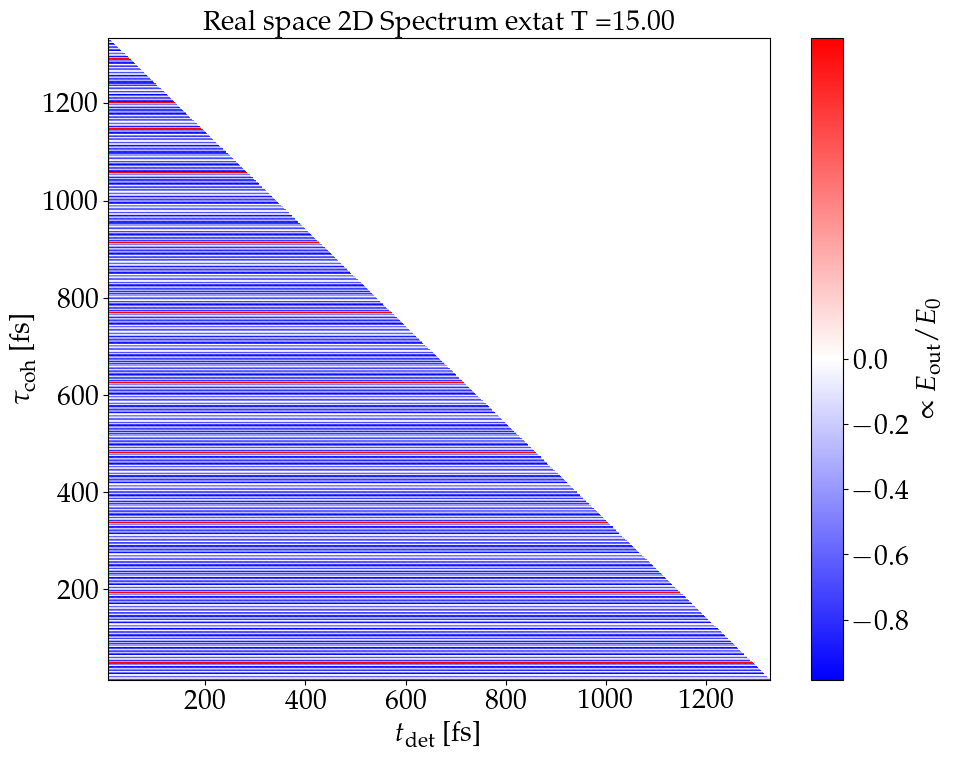

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


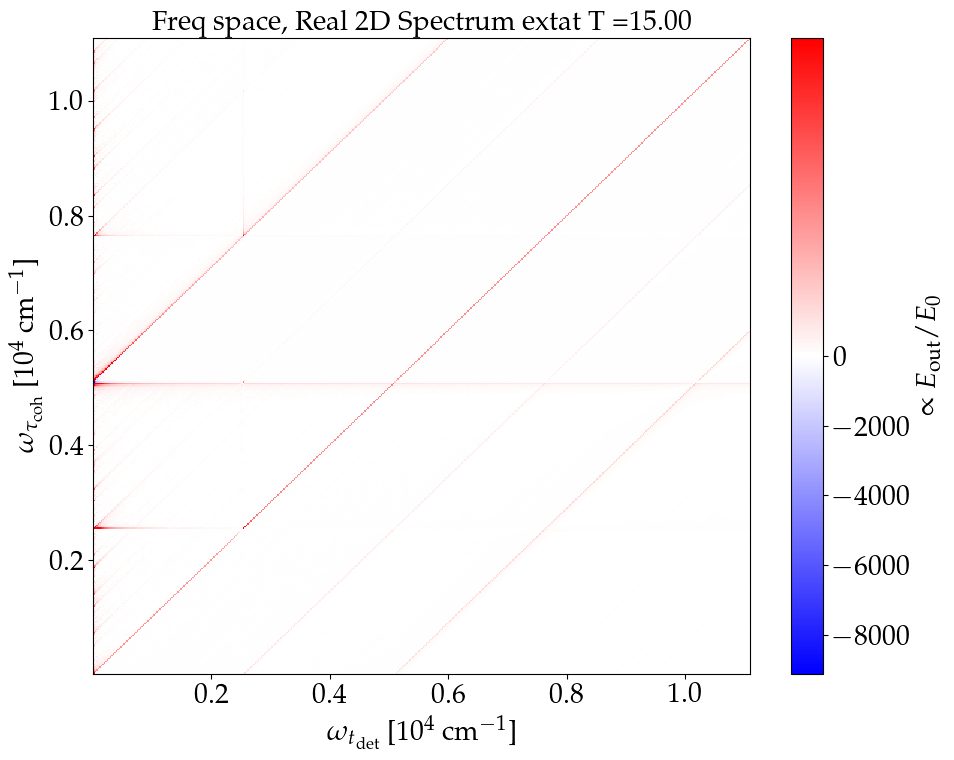

In [16]:
safe = False  # (**changeable**) decide if i want to save the plot to a svg file
positive = True  # (**changeable**) only plot one quadrant of the 2D-spectrum
plot_positive_color_map(
    (data_test_0[1], data_test_0[0], data_test_0[2]), T_wait=T_test, safe=safe
)
tfreqs = np.fft.fftfreq(len(data_test_0[1]), d=(data_test_0[1][1] - data_test_0[1][0]))
taufreqs = np.fft.fftfreq(
    len(data_test_0[0]), d=(data_test_0[0][1] - data_test_0[0][0])
)
plot_positive_color_map(
    (tfreqs, taufreqs, np.fft.fft2(data_test_0[2])),
    positive=positive,
    type="real",
    space="freq",
    T_wait=T_test,
    safe=safe,
)

In [51]:
# RESULTS from 2D Spectroscopy with all phases and times_T, already averaged over all phi
RESULT = get_all_results(phases, times_T)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/scipy/integrate/_ode.py:438: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


IntegratorException: Excess work done on this call. Try to increasing the nsteps parameter in the Options class

In [ ]:
# Example usage
global_time_result, global_freq_result = extend_and_plot_results(RESULT)